In [1]:
import numpy as np
import datetime
import pandas as pd
import seaborn as sns
import time
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import AdaBoostClassifier
from Pre_processing import *
import pickle
from dython.nominal import associations
from sklearn.metrics import r2_score

pd.set_option('mode.chained_assignment', None)

In [2]:
dbfile = open('milestone1_pickle', 'rb')     
db = pickle.load(dbfile)
dbfile.close()
print(db.keys())
model1 = db['model1']
model2 = db['model2']
top_feature = db['Top_features']

dict_keys(['model1', 'model2', 'Top_features'])


In [3]:
#Read data from file #
def getData(path):
    data = pd.read_csv(path)
    temp = []
    for i in data['national_team']:
        if type(i) != str:
            value = '0'
        else:
            value = '1'
        temp.append(value)
    data['national_team'] = temp
    
    return data
data = getData('player-value-prediction.csv')



mean_mode = get_mode_means(data)


In [4]:
mean_mode

{'id': 215308.41056882267,
 'name': 0    J. Rodríguez
 dtype: object,
 'full_name': 0    Adama Traoré
 1     Scott Brown
 dtype: object,
 'birth_date': 0    2/29/1992
 dtype: object,
 'age': 25.575367263106592,
 'height_cm': 174.90206920556963,
 'weight_kgs': 75.30426791060502,
 'positions': 0    CB
 dtype: object,
 'nationality': 0    England
 dtype: object,
 'overall_rating': 66.25767597298615,
 'potential': 71.4353547309058,
 'wage': 9888.37143663562,
 'preferred_foot': 0    Right
 dtype: object,
 'international_reputation(1-5)': 1.1107011070110702,
 'weak_foot(1-5)': 2.9467381466267493,
 'skill_moves(1-5)': 2.3585601893754786,
 'work_rate': 0    Medium/ Medium
 dtype: object,
 'body_type': 0    Normal
 dtype: object,
 'release_clause_euro': 4622436.456796832,
 'club_team': 0           AS Monaco
 1    Newcastle United
 2            RC Celta
 dtype: object,
 'club_rating': 69.3698696954916,
 'club_position': 0    SUB
 dtype: object,
 'club_jersey_number': 20.295240749773534,
 'club_j

In [5]:
def preprocessing(data):
    #Replace null value with mean at wage and value columns
    #split column 'position'
    data = data.loc[:, data.isnull().sum() < 0.25*data.shape[0]]
    temp = []
    for i in data['positions']:
        l = i.split(',')
        temp.append(l[0])
    data['positions'] = temp
    temp.clear()
    for i in data['work_rate']:
        l = i.split('/')
        temp.append(l[0])
    data['work_rate'] = temp
      
    data['value'].fillna(value=mean_mode['value'], inplace=True)
    data['wage'].fillna(value=mean_mode['wage'], inplace=True)
    
    
    data.dropna(how='any',inplace=True)

    Columns=['LS','ST','RS','LW','LF','CF','RF','RW','LAM','CAM','RAM','LM','LCM','CM','RCM','RM','LWB','LDM','CDM','RDM','RWB','LB','LCB','CB','RCB','RB']
    for i in Columns:
        position(i,data)

    #Date encodig
    date_toInt(data,'contract_end_year')
    date_toInt(data,'birth_date')
    date_toInt(data,'club_join_date')
    return data


data = preprocessing(data)

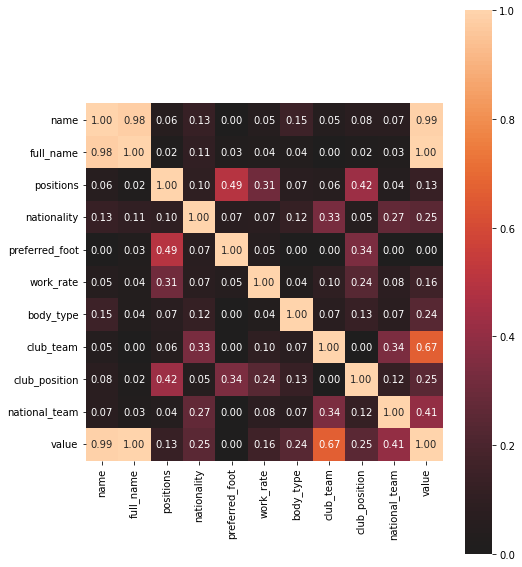

In [6]:
categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
l = data[categorical_columns]
l.insert(10,'value',data['value'])
##correlation for cat vars
# categorical_correlation = associations(
#        l, filename='categorical_correlation.png', figsize=(8, 10),)

In [7]:
#convert categories data to numbers

#cols=['nationality','positions','preferred_foot','work_rate','body_type','club_team','club_position']
data, encoders=Feature_Encoder(data,categorical_columns)

In [8]:

def preprocessing2(dt):
    
    #Drop columns which do not affect on our model
    dt=dt.drop(['id','name','full_name','birth_date'], axis = 1)
    return dt
data = preprocessing2(data)

In [9]:
#Split data
numerical_columns_selector = selector(dtype_exclude=object)
numerical_columns = numerical_columns_selector(data)
X=data[numerical_columns]
Y=data["value"]
#Get the correlation between the features
# data=data.iloc[:,:]
# corr = data.corr()
# #Top 50% Correlation training features with the Value
# top_feature = corr.index[abs(corr['value'])>0.46]
# #Correlation plot
# plt.subplots(figsize=(12, 8))
# top_corr = data[top_feature].corr()
# sns.heatmap(top_corr, annot=True)
# plt.show()


In [10]:
# top_feature = top_feature.delete(-1)
features = []
features.append(list(top_feature))
features.append(['reactions','composure','CM','RCM','ST','RS','CF','RF','CAM','RAM'])
# X.info
#X.insert(0,'club_team',data['club_team'])
features[0].append('club_team')
X = X[features[0]]


#Drop features that have high correlatin with other features 
X=X.drop(features[1], axis = 1)
# 
X.info

<bound method DataFrame.info of        overall_rating  potential      wage  international_reputation(1-5)  \
0                  64         65    1000.0                              1   
1                  72         72   11000.0                              2   
2                  71         78   10000.0                              1   
3                  72         72   33000.0                              1   
4                  64         71    1000.0                              1   
...               ...        ...       ...                            ...   
14354              65         68    2000.0                              1   
14358              64         64    4000.0                              1   
14359              60         72    1000.0                              1   
14360              82         82  115000.0                              3   
14361              60         68    1000.0                              1   

       release_clause_euro  club_rating  ba

In [11]:

#Feature Selection

#Split the data to training and testing sets
time1 = time.time()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20,shuffle=True,random_state=10)
X_train, X_test, Scaler = Preprocessing_Scaling(X_train, X_test)

# ###--------------model1--------- 
poly_features = PolynomialFeatures(degree=3)

# transforms the existing features to higher degree features.
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.transform(X_test)

# fit the transformed features to Linear Regression
# model1 = linear_model.LinearRegression()
# model1.fit(X_train_poly, y_train)
# time2 = time.time()
# print('training time ',time2-time1)
# predicting on training data-set
ypred=model1.predict(X_test_poly)
#print('Co-efficient of linear regression',poly_model.coef_)
#print('Intercept of linear regression model',poly_model.intercept_)
error = metrics.mean_squared_error(y_test, ypred)
print('Mean Square Error',error )
print('r2_score = ',r2_score(y_test,ypred))
print('accuracy1 = ', model1.score(X_test_poly, y_test)*100)


Mean Square Error 146159077572.1335
r2_score =  0.9952984509470437
accuracy1 =  99.52984509470437


In [13]:
time1 = time.time()

# model2 = linear_model.LinearRegression()
# model2.fit(X_train, y_train)
prediction = model2.predict(X_test)
print('Mean Square Error', metrics.mean_squared_error(np.asarray(y_test), prediction))
print('accuracy = ', model2.score(X_test, y_test)*100)
print('r2_score = ',r2_score(y_test,prediction))
time2 = time.time()
# print('training time ',time2-time1)


Mean Square Error 363217254391.70404
accuracy =  98.83162663122317
r2_score =  0.9883162663122317


In [15]:
def fillnaa(df , columns):
    
    #handel cat vars
    #print(df.isnull().sum())
    for i in columns:
        df[i].fillna(value=mean_mode[i], inplace=True)
    #print(df.isnull().sum())
    return df
def testfile(path,features,model):
    #Split data
    df = getData(path)
    df = fillnaa(df ,features[0] )
    df = preprocessing(df)
    df = encoder_transform(df,encoders.keys(),encoders )
    df = preprocessing2(df)
    
    xx=df[features[0]]
    xx=xx.drop(features[1], axis = 1)
    yy=df["value"]
    print(yy)
    xx = Scaler.transform(xx)
    xx_poly = poly_features.transform(xx)
    y_pred1 = model.predict(xx_poly)
    print('Predicted Value for DecisionTreeClassifierModel is : ' , y_pred1[:20])
    error = metrics.mean_squared_error(yy, y_pred1)
    print('Mean Square Error',error )
    print('accuracy1 = ', model.score(xx_poly, yy)*100)
    #print('Predicted class for DecisionTreeClassifierModel is : ' , Scaler.inverse_transform(y_pred1[:20]))
    #print(accuracy_score(yy, y_pred1))


testfile('player-test-samples1.csv',features,model1)

0    1200000
1     400000
2     375000
Name: value, dtype: int64
Predicted Value for DecisionTreeClassifierModel is :  [1171839.32438577  307625.23774295  296141.61877804]
Mean Square Error 5181588214.014766
accuracy1 =  96.47044133009402


In [16]:

# # initializing data to be stored in db
# # database
# db = {}
# db['model1'] = model1
# db['model2'] = model2
# db['Top_features'] = top_feature
# # Its important to use binary mode
# dbfile = open('milestone1_pickle', 'ab')

# # source, destination
# pickle.dump(db, dbfile)                     
# dbfile.close()

